In [1]:
import os
import numpy as np
import math
import joblib
import schedule
import pandas as pd
import time as st_time
from datetime import datetime, date, timedelta, time
os.environ['TZ'] ='America/New_York'

import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from ib_async import *
util.startLoop()

### Data Prep for Inferencing

In [22]:
ib = IB()
ib.connect(port=7496, clientId=4)

<IB connected to 127.0.0.1:7496 clientId=4>

In [5]:
contract = Contract(symbol='META', secType='STK', exchange='SMART', currency='USD')
ib.qualifyContracts(contract)

contract_vix = Contract(symbol= 'VIX', secType = 'IND',exchange = 'CBOE', currency='USD')
ib.qualifyContracts(contract_vix)

contract_nas = Contract(symbol= 'TQQQ', secType = 'STK',exchange = 'SMART', currency='USD')
ib.qualifyContracts(contract_nas)

[Contract(secType='STK', conId=72539702, symbol='TQQQ', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='TQQQ', tradingClass='NMS')]

In [6]:
class Data_Request :

    """
    Returns PD data containning equity price with specific time control

    Returns:
        pd: information regarding the contract of interst.
    """
    
    def __init__(self, list_days, contract, barsize, duration, *,specific_time= None, specific_pick_time= None):

        self.list_days = list_days
        self.contract = contract
        #self.init_date = init_date
        self.barsize = barsize
        self.duration = duration
        self.specific_time = specific_time # cut off time . Time object: time(14, 30, 0)
        self.specific_pick_time= specific_pick_time

    def D_request(self):

        his_df =pd.DataFrame()
        
        for i in range(len(self.list_days)):
            init_date=self.list_days[i]
            bars = ib.reqHistoricalData(self.contract, init_date, barSizeSetting=self.barsize, durationStr=self.duration, whatToShow="TRADES", useRTH=True)
            add_his_df = pd.DataFrame(bars)
            add_his_df['date'] = pd.to_datetime(add_his_df['date'])
            print(f'retriveing data for {init_date}')

            if self.specific_time is not None:
                cut_off = datetime.combine(self.list_days[i],self.specific_time)  # need logic if specific_time is defined
                pd_cut_off = pd.to_datetime(cut_off).tz_localize('US/Eastern')
            #datetime64_eastern = pd.Timestamp(date_time_str).tz_localize('US/Eastern')
                add_his_df = add_his_df[add_his_df['date'] > pd_cut_off]
            
            if self.specific_pick_time is not None:
                pick_time = datetime.combine(self.list_days[i],self.specific_pick_time)  # need logic if specific_time is defined
                pd_pick_time = pd.to_datetime(pick_time).tz_localize('US/Eastern')
            #datetime64_eastern = pd.Timestamp(date_time_str).tz_localize('US/Eastern')
                add_his_df = add_his_df[add_his_df['date'] == pd_pick_time]

            
            his_df = pd.concat([his_df, add_his_df], ignore_index=True)
            his_df['Date_Only'] = his_df['date'].dt.date
            print(len(his_df))

        
        return his_df


In [7]:
# picking out Friday and before specific-time data

#specific_time = time(14, 30, 0)
def data_filter_v46(df_initial, list_days, specific_time_before = None, specific_time_after= None, on_time= None):
    his_df = pd.DataFrame()

    df_trimmed = df_initial[df_initial['date'].dt.date.isin(list_days)]

    if specific_time_before is not None:

        his_df = df_trimmed[(df_trimmed['date'].dt.time < specific_time_before)]
        
            
    if specific_time_after is not None:

        his_df = df_trimmed[(df_trimmed['date'].dt.time >= specific_time_after)]

    if on_time is not None:
        his_df = df_trimmed[(df_trimmed['date'].dt.time == on_time)]

    if (specific_time_before is None and specific_time_after is None) and on_time is None:

        his_df = df_trimmed
        
    return his_df

In [8]:
def data_cleaning(df, in_days):
    df_his = pd.DataFrame()
    df_return = pd.DataFrame()
    
    df.drop_duplicates(inplace = True)
    df_his = df[df["Date_Only"].isin(in_days)]
    df_return = df_his[(df_his['date'].dt.time > time(9,29,40)) & (df_his['date'].dt.time < time(16,00))]

    for i in df_return['Date_Only'].unique():
        if df_return[df_return['Date_Only'] ==i].shape[0] % 390 != 0:
            print(i)
    
    return df_return

In [9]:

def data_sparcing_construc(df, sp_day, *, cut_time = None):
    #df_group = df.groupby("Date_Only").std(numeric_only=True)
    df_filter_prior = data_filter_v46(df, sp_day, specific_time_before = cut_time )
    df_group_prior = df_filter_prior.groupby("Date_Only").std(numeric_only=True)
    
    #df_filter_after = data_filter(df, sp_day, specific_time_after = cut_time )
    #df_group_after = df_filter_after.groupby("Date_Only").std(numeric_only=True)


    df_group_train =pd.DataFrame()
    #df_group_train['Target_std'] = pd.DataFrame(df_group_after[['open','high','low','close']].max(axis=1))
    df_group_train['prior_std'] = pd.DataFrame(df_group_prior[['open','high','low','close']].max(axis=1))
    df_group_train['prior_Vol'] = pd.DataFrame(df_filter_prior.groupby("Date_Only").mean()['volume'])
    df_group_train['prior_spread'] = df_filter_prior.groupby('Date_Only')['open'].max() - df_filter_prior.groupby('Date_Only')['open'].min()


    df_group_train['prior_range'] =pd.DataFrame(df_filter_prior.groupby('Date_Only')['close'].max() -df_filter_prior.groupby('Date_Only')['close'].min() )

    df_initial = df_filter_prior
    new_time = time(cut_time.hour, cut_time.minute -1)
    df_group_train['cut_open'] = df_initial[(df_initial['date'].dt.time == new_time)]['open'].values
    
    cut_name =['cut_1hr','cut_2hr','cut_3hr']
    for i in range(3):
        print(f'time avaiable {i}')
        prior = time(cut_time.hour - (i+1), cut_time.minute)
        df_group_train[cut_name[i]] = df_initial[(df_initial['date'].dt.time == new_time)]['open'].values- df_initial[(df_initial['date'].dt.time == prior)]['open'].values

    #df_group_train['Class_target'] = df_filter_after[(df_filter_after['date'].dt.time == time(15, 49, 0))]['close'].values- df_initial[(df_initial['date'].dt.time == new_time)]['open'].values
    
    return df_group_train, df_filter_prior, df_group_prior
    

In [10]:
def get_option_chain(symbol):
    contract = Stock(symbol=symbol, exchange='SMART', currency='USD')
    ib.qualifyContracts(contract)
    chains = ib.reqSecDefOptParams(underlyingSymbol=contract.symbol, futFopExchange="", underlyingSecType=contract.secType, underlyingConId=contract.conId)
    chain = [ c for c in chains if c.exchange =='SMART'][0]
    return chain

def get_options_chain_for_expiry(symbol, expiry, min_strike=0, max_strike=np.Inf):
    option_chain = get_option_chain(symbol)
    options=[]
    for strike in option_chain.strikes:
        if strike <= max_strike and strike >= min_strike:
            for right in ['C', 'P']:
                option = Option(symbol=symbol, lastTradeDateOrContractMonth=expiry, strike=strike, right=right, exchange='SMART', currency='USD')
                options.append(option)
    valid_options=ib.qualifyContracts(*options)
    return valid_options


In [11]:
def round_up_to_nearest_ten(num):
  """Rounds a number up to the nearest ten."""
  return math.ceil(num / 10) * 10


def find_closest_number(numbers, target):
  """
  Finds the number in a list that is closest to a target number.

  Args:
    numbers: A list of numbers.
    target: The target number.

  Returns:
    The number in the list that is closest to the target number.
  """
  if not numbers:
    return None
  
  closest_number = numbers[0]
  min_difference = abs(numbers[0] - target)

  for number in numbers:
    difference = abs(number - target)
    if difference < min_difference:
      min_difference = difference
      closest_number = number

  return closest_number


### Inferencing Data Set Collection ###

In [12]:
now =datetime.now()
#print(now.date())
#print(now.time().minute)
#infer_time = time(now.time().hour, now.time().minute -15 )
#infer_time = time(now.time().hour, now.time().minute)
#inferencing_date = now.date() - timedelta(3)
inferencing_date = now.date() 
#infer_time = time(14,30,0)
infer_time = time(now.time().hour, now.time().minute)
## put option expiration date in 20250411 format
to_day = "20250411"
print(to_day)

20250411


In [13]:
barsize ="30 secs"
duration = "1 D"
#DR_stock_meta = Data_Request( " ",contract, barsize, duration)
DR_stock_meta = Data_Request([inferencing_date], contract, barsize, duration)
df_all_days_stock = DR_stock_meta.D_request()

DR_IND_VIX = Data_Request([inferencing_date], contract_vix, barsize, duration)
DR_STK_TQQQ = Data_Request([inferencing_date], contract_nas, barsize, duration)
df_all_days_VIX = DR_IND_VIX.D_request()
df_all_days_TQQQ = DR_STK_TQQQ.D_request()

df_stock = data_cleaning(df_all_days_stock,[inferencing_date])
df_VIX = data_cleaning(df_all_days_VIX,[inferencing_date])
df_TQQQ = data_cleaning(df_all_days_TQQQ,[inferencing_date])


df_group_train, df_filter_prior, df_group_prior = data_sparcing_construc(df_all_days_stock, [inferencing_date], cut_time= infer_time)
df_group_train_tqqq, *_ = data_sparcing_construc(df_all_days_TQQQ, [inferencing_date], cut_time= infer_time)

# need to check
vix_infer_time = time(now.time().hour -1, now.time().minute )
#vix_infer_time = infer_time 
df_group_train_vix, *_ = data_sparcing_construc(df_all_days_VIX, [inferencing_date], cut_time= vix_infer_time)

df_final_joninted_vix=pd.DataFrame()
df_final_joninted_all=pd.DataFrame()

df_group_train_vix.columns =['vix_prior_std','vix_Vol','vix_pr_spread','vix_prior_range','vix_cut_open','vix_cut_1hr','vix_cut_2hr','vix_cut_3hr']
df_final_jointed_vix = pd.concat([df_group_train,df_group_train_vix], axis=1)
df_group_train_tqqq.columns =['tqqq_prior_std','tqqq_Vol','tqqq_pr_spread','tqqq_prior_range','tqqq_cut_open','tqqq_cut_1hr','tqqq_cut_2hr','tqqq_cut_3hr']
df_final_jointed_all = pd.concat([df_final_jointed_vix,df_group_train_tqqq], axis=1)
df_final_jointed_all.drop(['vix_Vol'], axis=1, inplace=True)

df_final_jointed_all

retriveing data for 2025-04-07
546
retriveing data for 2025-04-07
1266
retriveing data for 2025-04-07
546
2025-04-07
2025-04-07
2025-04-07
time avaiable 0
time avaiable 1
time avaiable 2
time avaiable 0
time avaiable 1
time avaiable 2
time avaiable 0
time avaiable 1
time avaiable 2


,prior_std,prior_Vol,prior_spread,prior_range,cut_open,cut_1hr,cut_2hr,cut_3hr,vix_prior_std,vix_pr_spread,...,vix_cut_2hr,vix_cut_3hr,tqqq_prior_std,tqqq_Vol,tqqq_pr_spread,tqqq_prior_range,tqqq_cut_open,tqqq_cut_1hr,tqqq_cut_2hr,tqqq_cut_3hr
Date_Only,,,,,,,,,,,,,,,,,,,,,
2025-04-07,9.839175,30107.650735,54.82,54.83,524.34,8.81,14.31,4.28,3.525508,21.55,...,-5.12,-1.04,1.815337,493760.402574,11.46,11.48,42.76,2.28,3.05,0.31


In [14]:
df_all_days_VIX

,date,open,high,low,close,volume,average,barCount,Date_Only
0,2025-04-07 02:15:00-05:00,60.13,60.13,60.13,60.13,0.0,0.0,1,2025-04-07
1,2025-04-07 02:15:30-05:00,60.13,60.13,60.13,60.13,0.0,0.0,0,2025-04-07
2,2025-04-07 02:16:00-05:00,60.13,60.13,60.13,60.13,0.0,0.0,0,2025-04-07
3,2025-04-07 02:16:30-05:00,60.13,60.13,60.13,60.13,0.0,0.0,0,2025-04-07
4,2025-04-07 02:17:00-05:00,60.13,60.13,60.13,60.13,0.0,0.0,0,2025-04-07
...,...,...,...,...,...,...,...,...,...
1261,2025-04-07 13:00:30-05:00,44.65,44.65,44.45,44.45,0.0,0.0,2,2025-04-07
1262,2025-04-07 13:01:00-05:00,44.71,44.89,44.71,44.89,0.0,0.0,2,2025-04-07
1263,2025-04-07 13:01:30-05:00,44.96,45.07,44.96,45.07,0.0,0.0,2,2025-04-07
1264,2025-04-07 13:02:00-05:00,45.17,45.21,45.17,45.21,0.0,0.0,2,2025-04-07


[531.28048756] [523.02] [514.75951244]


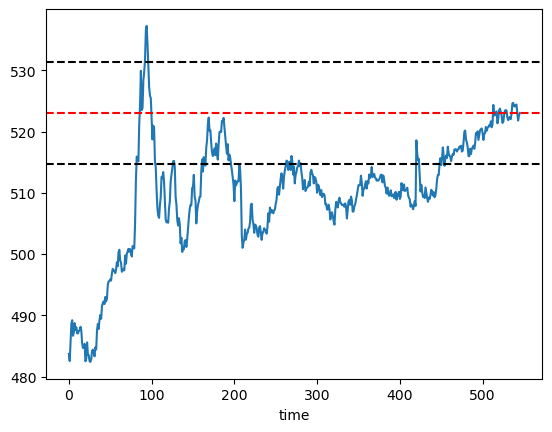

In [15]:
### use model to predict block

df_final_jointed_all.reset_index(inplace=True)
inference_data = df_final_jointed_all.drop('Date_Only', axis=1)
inference_data.shape

filename = 'xgb_model4_price_spread.joblib'
loaded_model = joblib.load(filename)

yhat = loaded_model.predict(inference_data)

Entry = df_all_days_stock.tail(1)['close'].values

y_value = Entry
y_value_p = Entry + yhat[0]
y_value_m = Entry - yhat[0]

print(y_value_p, Entry ,y_value_m )

df_all_days_stock['close'].plot()
plt.xlabel('time')
plt.axhline(y=y_value, color='r', linestyle='--', label=f'y = {y_value}')
plt.axhline(y=y_value_p, color='black', linestyle='--', label=f'y = {y_value_p}')
plt.axhline(y=y_value_m, color='black', linestyle='--', label=f'y = {y_value_m}')

In [18]:
###  GETTTING OPTION information
Rd_up_Entry = round_up_to_nearest_ten(Entry[0])

# getting valid option chains

valid_options = get_options_chain_for_expiry("META", to_day , min_strike= Rd_up_Entry  -30, max_strike=Rd_up_Entry +30,)
#print(valid_options)

list_strke = []
for list_str in valid_options:
    list_strke.append(list_str.strike)
    
### OPTION to find closes available strike price

upper_strk_number = find_closest_number(list_strke, y_value_p[0])

#global Up_Call
Up_Call = upper_strk_number +5

lower_strk_number = find_closest_number(list_strke, y_value_m[0])

#global Down_Put
Down_Put = lower_strk_number - 5 

tickers_dict = {}
    
for option in valid_options:
    tickers_dict[(option.right, option.strike)] = ib.reqMktData(contract =option, genericTickList="", snapshot=False, regulatorySnapshot=False)

## call empty call to wait
ib.sleep(4)
###
ticker_call_to_sell_target = tickers_dict['C', Up_Call]
UCV = ticker_call_to_sell_target.midpoint()

ticker_put_to_sell_target = tickers_dict['P', Down_Put]
LPV = ticker_put_to_sell_target.midpoint()

print(f'current price({Entry})')
print(f'upper_strike ({Up_Call}) at {UCV}')
print(f'lower_strike ({Down_Put}) at {LPV}')

#############################
#SELL options
#############################

#
#get price of the asset

spot = ib.reqMktData(contract = contract, genericTickList="", snapshot=False, regulatorySnapshot=False)
stock_price = spot.last

# Sample DataFrame
df = pd.DataFrame([{'time':datetime.now(),'upper_Call_value': UCV, 'stock_price':stock_price, 'lower_Put_value': LPV}])

df.to_pickle('price_move.pkl')



current price([523.02])
upper_strike (537.5) at 11.925
lower_strike (510.0) at 13.975


In [19]:
def job(valid_options, Up_Call, Down_Put ):
    
    tickers_dict = {}
    
    for option in valid_options:
        tickers_dict[(option.right, option.strike)] = ib.reqMktData(contract =option, genericTickList="", snapshot=False, regulatorySnapshot=False)

    ib.sleep(3)
    ticker_call_to_sell_target = tickers_dict['C', Up_Call]
    UCV = ticker_call_to_sell_target.midpoint()
    
    ticker_put_to_sell_target = tickers_dict['P', Down_Put]
    LPV = ticker_put_to_sell_target.midpoint()


    spot = ib.reqMktData(contract = contract, genericTickList="", snapshot=False, regulatorySnapshot=False)
    stock_price = spot.last
    
    
    print(f'current price({stock_price})')
    print(f'upper_strike price({Up_Call})')
    print(f'upper_strike price({Down_Put})')

    df = pd.read_pickle('price_move.pkl')
    
    new_row = pd.DataFrame([{'time':datetime.now(),'upper_Call_value': UCV, 'stock_price':stock_price, 'lower_Put_value': LPV}])

    # Append the new row using concat
    df = pd.concat([df, new_row], ignore_index=True)
    
    df.to_pickle('price_move.pkl')
    print(df)

In [23]:
#import schedule
#import time as st_time

# def job():
#     # Replace this with the code you want to run
#     print("Running script...", datetime.datetime.now())

def run_within_time_window(start_time_str, end_time_str, interval_seconds):
    start_time = datetime.strptime(start_time_str, '%H:%M:%S').time()
    end_time = datetime.strptime(end_time_str, '%H:%M:%S').time()

    while True:
        now = datetime.now()
        current_time = now.time()

        if start_time <= current_time <= end_time:
            schedule.run_pending()
        elif current_time > end_time:
            print("Time window ended.")
            break
        else:
            print("Waiting for time window...")

        ib.sleep(10)

if __name__ == "__main__":
    start_time_str = '13:05:00'  # Start time (HH:MM:SS)
    end_time_str = '16:00:00'    # End time (HH:MM:SS)
    interval_seconds = 120   # Run every hour

    schedule.every(interval_seconds).seconds.do(job, valid_options = valid_options, Up_Call = Up_Call,  Down_Put = Down_Put)

    run_within_time_window(start_time_str, end_time_str, interval_seconds)

current price(nan)
upper_strike price(537.5)
upper_strike price(510.0)
                        time  upper_Call_value  stock_price  lower_Put_value
0 2025-04-07 14:03:33.884275            11.925          NaN           13.975
1 2025-04-07 14:04:56.721003            11.750       522.23           13.800
2 2025-04-07 14:05:59.744786            11.225       520.31           14.725
3 2025-04-07 14:07:02.886504            10.850       518.73           15.500
4 2025-04-07 14:08:06.071974            11.050       519.73           15.025
5 2025-04-07 14:15:53.227794            10.925          NaN           15.400
current price(519.91)
upper_strike price(537.5)
upper_strike price(510.0)
                        time  upper_Call_value  stock_price  lower_Put_value
0 2025-04-07 14:03:33.884275            11.925          NaN           13.975
1 2025-04-07 14:04:56.721003            11.750       522.23           13.800
2 2025-04-07 14:05:59.744786            11.225       520.31           14.725
3 2025-0

<Axes: xlabel='time'>

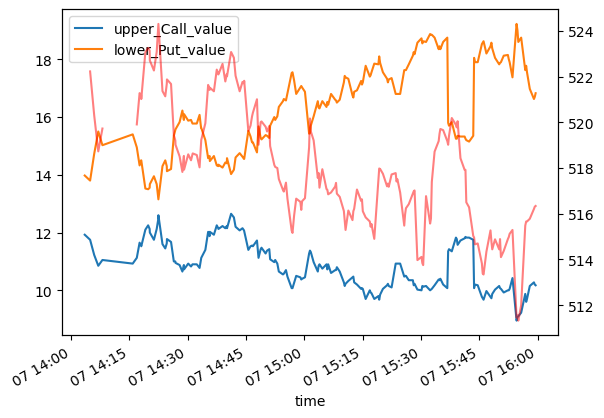

In [4]:
df_review = pd.read_pickle('price_move.pkl')

df_review['time'] =df_review['time'].dt.strftime("%Y-%m-%d %H:%M:%S")
df_review['time'] = pd.to_datetime(df_review['time'])
df_review.index = df_review['time']
df_review.drop('time',axis=1, inplace=True)
ax = df_review[['upper_Call_value','lower_Put_value']].plot()
ax2 = ax.twinx()
df_review['stock_price'].plot(ax=ax2, color='red',alpha=0.5)

In [ ]:
df_review